# Convert Twitter API JSON file to NetworkX & Gephi

Developed by Chris Allison - @ToferC

This notebook takes a custom JSON dict of tweets pulled from the Twitter API, extracts the key data desired and creates first a NetworkX Graph and then exports to a Gephi file.

Tweets are collected by twitter_to_json.py and placed in the results directory with the title "search_"query_name".json


In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import tweepy
import os
import datetime, time
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import re
import json

%matplotlib inline

In [2]:
# Set up source and data directories - configure these as required

home_dir = "/home/chris/GitHub/Twitter_graphing_python/results"
save_dir = "/home/chris/Documents/Gephi/twitter"

In [3]:
# Enter your search queries here separated by spaces - 
# You must have already run search_twitter_to_json.py for the query

search_queries = "gc2020".split()

### Processing functions

The following functions are used by the main script to prep data

In [4]:
def find_user(tweet_id, tweet_dict):
    # Find tweet author based on tweet status ID
    try:
        x = tweet_dict[tweet_id]['user_screen_name']
    except KeyError:
        x = None # User is out of scope
    return x

In [5]:
first_cap_re = re.compile('(.)([A-Z][a-z]+)')
all_cap_re = re.compile('([a-z0-9])([A-Z])')

def convert(name):
    # Convert text to camel_case
    s1 = first_cap_re.sub(r'\1_\2', name)
    return all_cap_re.sub(r'\1_\2', s1).lower()

In [8]:
users = {}

# Full function for network graphing

In [9]:
def twitter_data_to_graph(search_query):
    # Convert JSON file of tweets to NetworkX Graph and Gephi graph file
    
    # Set up empty strings for NTLK analysis
    full_tweets = ""
    full_hashtags = ""
    
    # Create dict for storing user data
    
    for sq in search_query:
        # Open source files for each query
        
        fname = open(os.path.join(home_dir, 'converted_{}.json'.format(sq)))
        
        # Easily load JSON files with Pandas
        df = pd.read_json(fname, convert_axes=False)
        
        # Convert DF to dict for easier assignment
        tweets = df.to_dict(orient="dict")
        
        for t in tweets:
    
            # Convert hashtags to string
            n = []
            if tweets[t]['hashtags']:
                for i in tweets[t]['hashtags']:
                    n.append(i.lower())
                tweets[t]['hashtags'] = " ".join(n)
            else:
                tweets[t]['hashtags'] = ""

            # Convert user-mentions to string
            n = []
            if tweets[t]['user_mentions']:
                for i in tweets[t]['user_mentions']:
                    n.append(i.lower())
                tweets[t]['user_mentions'] = " ".join(n)
            else:
                tweets[t]['user_mentions'] = ""
                
               users = {} # Set user name to save a lot of typing
            name = str(tweets[t]['user_screen_name']).lower()
            
            # User already exists
            try:
                # Add hashtags used by the user
                users[name]['hashtags'] += " {}".format(
                tweets[t]['hashtags'])

                # Add user-mentions used by the user
                users[name]['user_mentions'] += " {}".format(
                tweets[t]['user_mentions'])

                # Add tweet id_strings used by the user
                users[name]['id_str'] += " {}".format(
                tweets[t]['id_str'])

                # We are not adding additional info to date as it will disrupt dynamic graphs
                pass

                # Add texts from additional tweets and date info as text
                users[name]['text'] += "\n\n{}\n{}".format(
                tweets[t]['text'], tweets[t]['date'])

                # Count user tweets
                users[name]['user_tweets'] += 1

            except KeyError:

                # Key doesn't exist, so add user
                users[name] = {}

                users[name]['screen_name'] = name
                users[name]['id_str'] = tweets[t]['id_str']
                users[name]['date'] = tweets[t]['date']
                users[name]['text'] = tweets[t]['text']
                users[name]['hashtags'] = tweets[t]['hashtags']
                users[name]['user_mentions'] = str(tweets[t]['user_mentions'])
                users[name]['user_tweets'] = 1
                
            full_tweets += "{} ".format(tweets[t]['text'])
            full_hashtags += "{} ".format(tweets[t]['hashtags'])
                
        # Remove duplicate hashtags
        
        for u in users:
            users[u]['hashtags'] = " ".join(set(users[u]['hashtags'].split(' ')))
        
        # Create one node for each tweet with embedded data - Graph N
        for u in users:
            N.add_node(str(users[u]['screen_name']), attr_dict=users[u])
            
        # Create edge_list

        edge_dict = {}

        for u in users:
            temp = []

            # Prep user-mentions
            try:
                um = users[u]['user_mentions'].split(" ")
            except AttributeError:
                um = []


            # Create edge list keys and weight
            temp = um

            # Remove any empty elements in list
            for e in temp:
                
                # Remove any empty elements in list
                if str(e) == "" or str(e) == 'None':
                    pass
                # Add edges to dict
                else:
                    try:
                        edge_dict[str([users[u]['screen_name'], str(e)]).lower()]['weight'] += 1

                    except KeyError:
                        edge_dict[str([users[u]['screen_name'], str(e)]).lower()] = {}
                        edge_dict[str([users[u]['screen_name'], str(e)]).lower()]['node'] = users[u]['screen_name']
                        edge_dict[str([users[u]['screen_name'], str(e)]).lower()]['target'] = str(e)
                        edge_dict[str([users[u]['screen_name'], str(e)]).lower()]['weight'] = 1
                        
        # Add edges for @mentions and replies to users
        for e in edge_dict:
            N.add_edge(edge_dict[e]['node'],
                       edge_dict[e]['target'],
                       weight=edge_dict[e]['weight'])

        # Insert any data analysis here
        print("Converting and analyzing search query: {}".format(sq))
        print("Nodes: {}, Edges: {}".format(len(N.nodes()), len(N.edges())))
        
        # NLTK analysis
        
        tweet_tokens = word_tokenize(full_tweets)
        hashtag_tokens = word_tokenize(full_hashtags)
        
        text = nltk.Text(tweet_tokens)
        clean_tweets = [w for w in set(text) if w.lower() not in stopwords.words('english')]
        
        hts = nltk.Text(hashtag_tokens)
        
        print('\nFrequency Distribution for hashtags:')
        fdist1 = nltk.FreqDist(hts)
        V = fdist1.most_common(n=50)
        print([y for y in V])
        fdist1.plot(30, cumulative=False)
        
    # Write G graph in gexf for Gephi
    file_name = "{}_graph_{}.gexf".format(
        convert("_".join(search_queries)),
        datetime.datetime.now())
    
    nx.write_gexf(N, os.path.join(save_dir, file_name))
    print("New file {} saved to {}.".format(file_name, save_dir))
        

In [10]:
N = nx.MultiDiGraph()

Converting and analyzing search query: gc2020
Nodes: 601, Edges: 1340

Frequency Distribution for hashtags:
[('#', 2148), ('gc2020', 1059), ('ncr', 84), ('rcn', 75), ('ottawa', 39), ('prairieinnovationfair', 32), ('innovation', 28), ('cra2020yeg', 27), ('clerkreport', 23), ('goc', 19), ('leadersgc', 19), ('canada150', 19), ('gccollab', 17), ('halifax', 15), ('mentalhealth', 15), ('gctools', 14), ('inac', 14), ('reconciliation', 14), ('canadabeyond150', 14), ('dyk', 12), ('aanc', 12), ('yzf', 12), ('bp2020', 11), ('vancouver', 11), ('ykinnovationfair', 10), ('innovationfair', 10), ('outilsgc', 9), ('moncton', 9), ('cdnpoli', 8), ('fedtalk', 8), ('yeg', 8), ('blog', 8), ('opengov', 8), ('opendata', 8), ('toddcast', 7), ('gcconnex', 7), ('réconciliation', 7), ('fedstarter', 7), ('opengovcan', 6), ('accessiblegc', 6), ('to', 6), ('blippar', 6), ('ps', 6), ('harassment', 6), ('tbt', 5), ('fixphoenix', 5), ('gcaccessible', 5), ('digitalcollaboration', 5), ('mtl', 5), ('toronto', 5)]


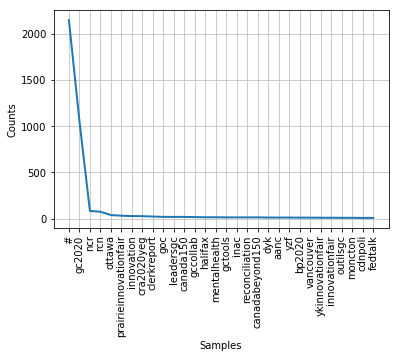

New file gc2020_graph_2017-07-05 16:06:57.828885.gexf saved to /home/chris/Documents/Gephi/twitter.


In [11]:
twitter_data_to_graph(search_queries)

## You're done!  Now go check out your graph file in Gephi!

In [14]:
users['@timsargent']

KeyError: '@timsargent'